### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Friday, Mar 5th at 11.59pm CST
---

In [94]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.stats import norm
from scipy.integrate import trapz
from pylab import rcParams
import scipy
rcParams['figure.figsize'] = 15,8

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

For heteroscedastic Gaussian data (from Lecture 5),

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [95]:
data1=np.load('../../homeworks/hw_data/hw4_data_1.npy',allow_pickle=True)

# first calculate sample mean
mu_num=np.sum(data1[:,0]/(data1[:,1]**2))
mu_denom=np.sum(1/data1[:,1]**2)    
mu_hat=mu_num/mu_denom

# next calculate standard error on sample mean
sigma_mu=mu_denom**-0.5

print("Sample Mean: {:.2f}".format(mu_hat))
print("Standard Error of Sample Mean: {:.2f}".format(sigma_mu))

Sample Mean: 4.94
Standard Error of Sample Mean: 0.43


2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

From Lecture 5.

$${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

In [96]:
def lnlike(mu,x,sigma): #x and sigma are vectors, mu is a float
    return np.sum([(x[i]-mu)**2/(2*sigma[i]**2) for i in range(len(x))])


f_lnlike = lambda mu: lnlike(mu,x=data1[:,0],sigma=data1[:,1])

mu0=2 #initial guess
mu_fit = optimize.fmin(f_lnlike, mu0)
print('###########################################')
print("Best-fit mean voltage: {:.2f}".format(mu_fit[0]))

Optimization terminated successfully.
         Current function value: 2.807251
         Iterations: 19
         Function evaluations: 38
###########################################
Best-fit mean voltage: 4.94


3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

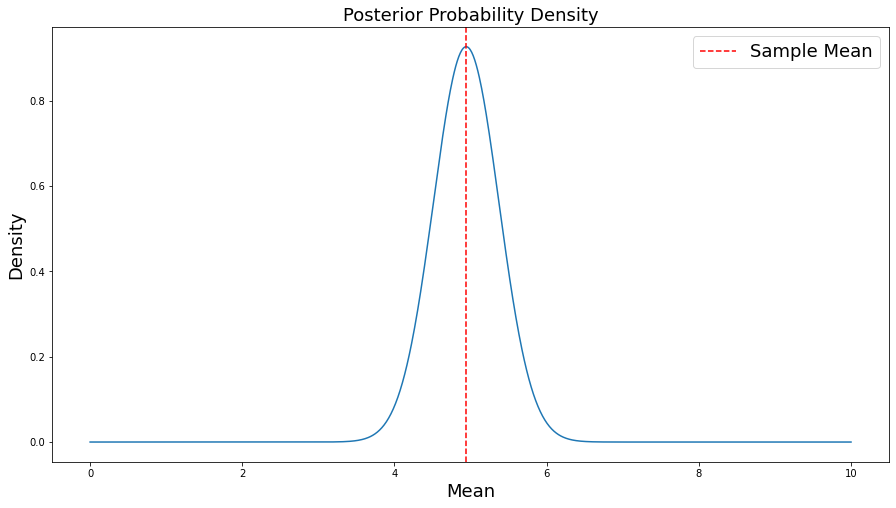

In [97]:
# In this case, theta is a list of possible mean values
def prior(theta,minimum,maximum):
    # normalized uniform distribution
    height=1/(maximum-minimum)
    prior=np.where( ((theta>minimum)&(theta<maximum)), height, 0  ) #return 0 outside of bounds
    return prior

def likelihood(data,theta):
    # grab ln likelihood
    lnlikelihood=np.asarray([lnlike(i,data[:,0],data[:,1]) for i in theta])
    lnlikelihood*=-1
    # convert to likelihood (not normalized)
    like=np.exp(lnlikelihood)
    # normalize likelihood
    like_area=trapz(y=like,x=theta)
    like_norm=like/like_area
    
    return like_norm
    
    
    
theta=np.linspace(0,10,num=1000)

pri=prior(theta,minimum=3,maximum=7)
like=likelihood(data1,theta)
post=pri*like
# normalize posterior prob
post_area_uniform=trapz(y=post,x=theta)
post_norm1=post/post_area_uniform





plt.plot(theta,post_norm1)
plt.axvline(mu_hat,c='r',ls='--',label='Sample Mean')
plt.xlabel('Mean',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Posterior Probability Density',fontsize=18)
plt.legend(loc='best',fontsize=18)


4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

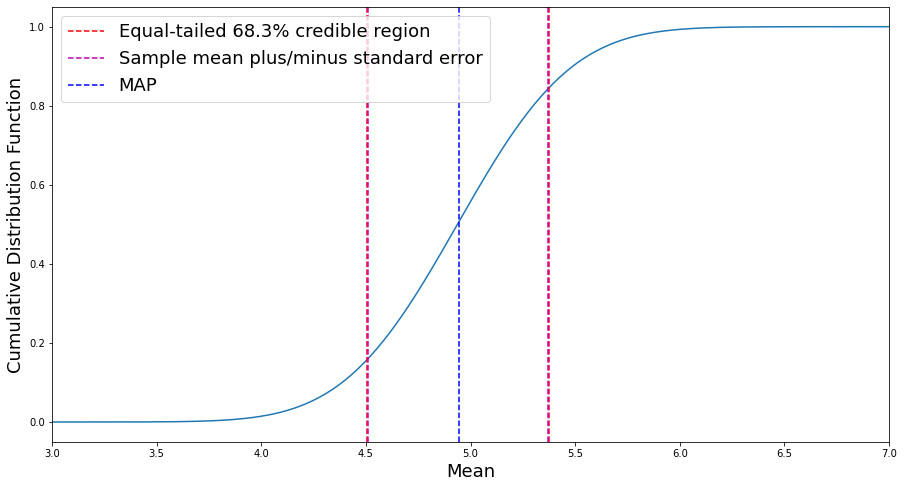

In [98]:
alpha=1-0.683

dx=theta[1]-theta[0]
post_cdf=np.cumsum(post_norm1)*dx
low_mask=post_cdf<=alpha/2
low_tail_theta=np.amax(theta[low_mask])

high_mask=post_cdf>=1-alpha/2
high_tail_theta=np.amin(theta[high_mask])

MAP=theta[np.argmax(post_norm1)]

plt.plot(theta,post_cdf)
plt.axvline(low_tail_theta,c='r',ls='--',label='Equal-tailed 68.3% credible region')
plt.axvline(high_tail_theta,c='r',ls='--')

plt.axvline(mu_hat-sigma_mu,c='m',ls='--',label='Sample mean plus/minus standard error')
plt.axvline(mu_hat+sigma_mu,c='m',ls='--')

plt.axvline(MAP,c='b',ls='--',label='MAP')

plt.xlim(3,7)
plt.xlabel('Mean',fontsize=18)
plt.ylabel('Cumulative Distribution Function',fontsize=18)
plt.legend(loc='best',fontsize=18)

<font color='red'>The Equal-tailed 68.3% credible region is very similar to the sample mean plus/minus the standard error</font>

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

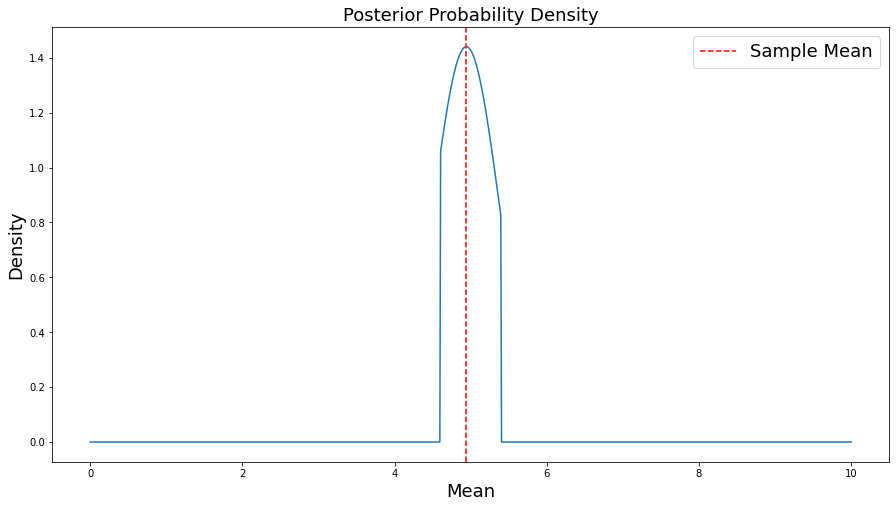

In [99]:
pri=prior(theta,minimum=4.6,maximum=5.4)
like=likelihood(data1,theta)
post=pri*like
# normalize posterior prob
post_area=trapz(y=post,x=theta)
post_norm2=post/post_area

plt.plot(theta,post_norm2)
plt.axvline(mu_hat,c='r',ls='--',label='Sample Mean')
plt.xlabel('Mean',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Posterior Probability Density',fontsize=18)
plt.legend(loc='best',fontsize=18)

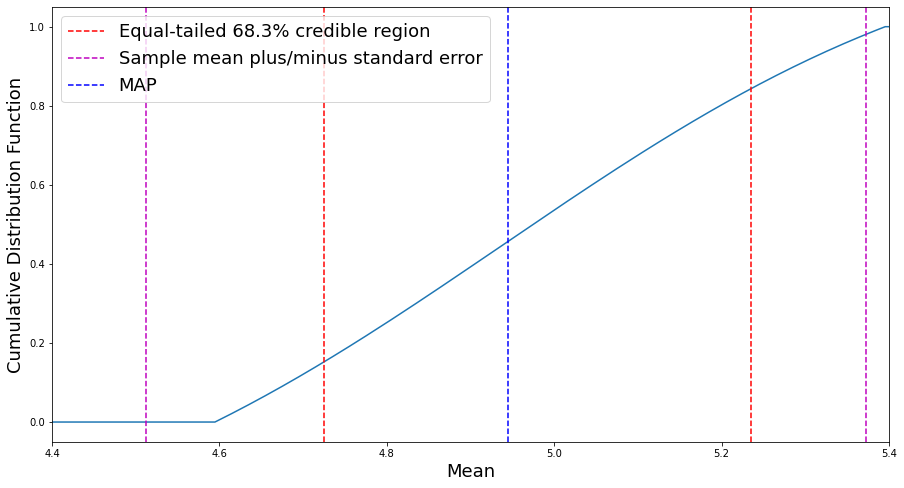

In [100]:
alpha=1-0.683

dx=theta[1]-theta[0]
post_cdf=np.cumsum(post_norm2)*dx
low_mask=post_cdf<=alpha/2
low_tail_theta=np.amax(theta[low_mask])

high_mask=post_cdf>=1-alpha/2
high_tail_theta=np.amin(theta[high_mask])

MAP=theta[np.argmax(post_norm2)]

plt.plot(theta,post_cdf)
plt.axvline(low_tail_theta,c='r',ls='--',label='Equal-tailed 68.3% credible region')
plt.axvline(high_tail_theta,c='r',ls='--')

plt.axvline(mu_hat-sigma_mu,c='m',ls='--',label='Sample mean plus/minus standard error')
plt.axvline(mu_hat+sigma_mu,c='m',ls='--')

plt.axvline(MAP,c='b',ls='--',label='MAP')

plt.xlim(4.4,5.4)
plt.xlabel('Mean',fontsize=18)
plt.ylabel('Cumulative Distribution Function',fontsize=18)
plt.legend(loc='best',fontsize=18)

<font color='red'>When your sampling region for theta is not wide enough, the equal-tailed 68.3% credible region underestimates the uncertainty given by the standard error</font>

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

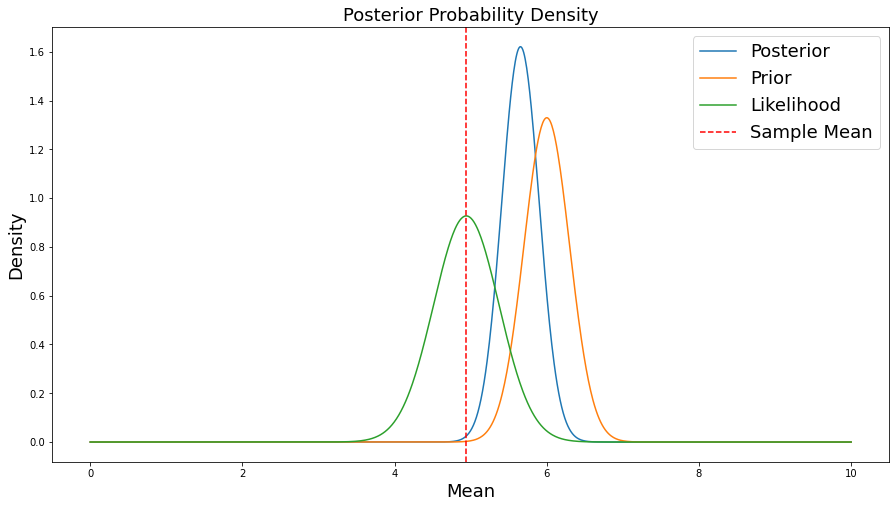

In [101]:
mu_prior=6
sigma_prior=0.3

def norm_prior(theta,mu,sigma):
    return norm.pdf(theta,loc=mu,scale=sigma)


pri=norm_prior(theta,mu=mu_prior,sigma=sigma_prior)
like=likelihood(data1,theta)
post=pri*like
# normalize posterior prob
post_area=trapz(y=post,x=theta)
post_norm3=post/post_area



plt.plot(theta,post_norm3,label='Posterior')
plt.plot(theta,pri,label='Prior')
plt.plot(theta,like,label='Likelihood')
plt.axvline(mu_hat,c='r',ls='--',label='Sample Mean')
plt.xlabel('Mean',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Posterior Probability Density',fontsize=18)
plt.legend(loc='best',fontsize=18)
    

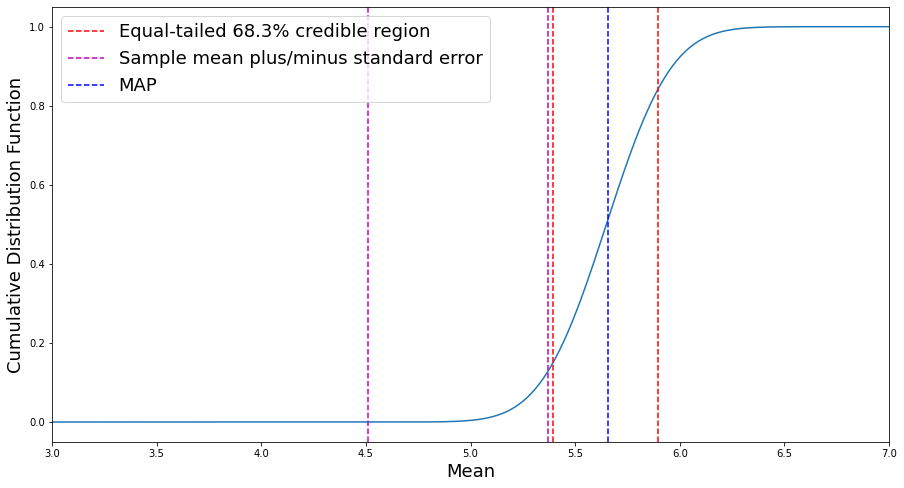

In [102]:
alpha=1-0.683

dx=theta[1]-theta[0]
post_cdf=np.cumsum(post_norm3)*dx
low_mask=post_cdf<=alpha/2
low_tail_theta=np.amax(theta[low_mask])

high_mask=post_cdf>=1-alpha/2
high_tail_theta=np.amin(theta[high_mask])

MAP=theta[np.argmax(post_norm3)]

plt.plot(theta,post_cdf)
plt.axvline(low_tail_theta,c='r',ls='--',label='Equal-tailed 68.3% credible region')
plt.axvline(high_tail_theta,c='r',ls='--')

plt.axvline(mu_hat-sigma_mu,c='m',ls='--',label='Sample mean plus/minus standard error')
plt.axvline(mu_hat+sigma_mu,c='m',ls='--')

plt.axvline(MAP,c='b',ls='--',label='MAP')

plt.xlim(3,7)
plt.xlabel('Mean',fontsize=18)
plt.ylabel('Cumulative Distribution Function',fontsize=18)
plt.legend(loc='best',fontsize=18)

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

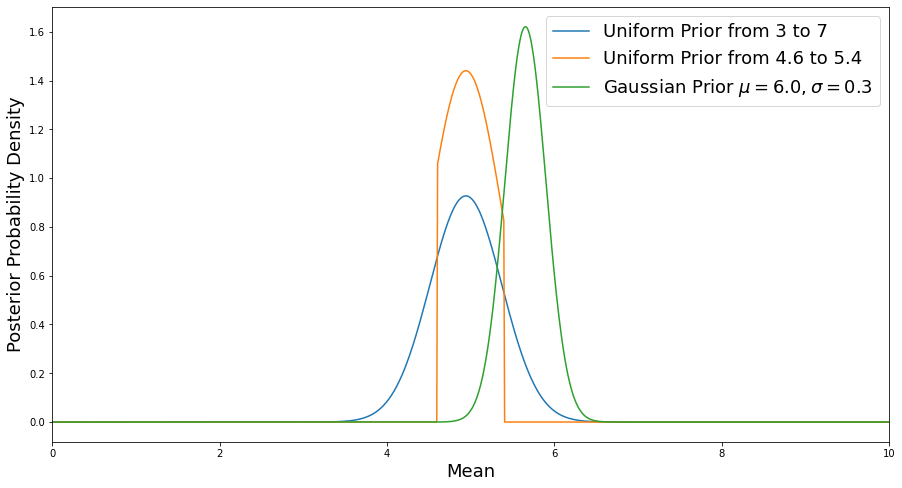

In [103]:
plt.xlim(0,10)
plt.plot(theta,post_norm1,label='Uniform Prior from 3 to 7')
plt.plot(theta,post_norm2,label='Uniform Prior from 4.6 to 5.4')
plt.plot(theta,post_norm3,label=r'Gaussian Prior $\mu={:.1f},\sigma={:.1f}$'.format(mu_prior,sigma_prior))

plt.xlabel('Mean',fontsize=18)
plt.ylabel('Posterior Probability Density',fontsize=18)
plt.legend(loc='best',fontsize=18)

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

In [105]:
def delta_prior(theta,mu,width):
    return ( 1/(np.absolute(width)*np.sqrt(np.pi)) ) * np.exp(-((theta-mu)/width)**2)

pri=delta_prior(theta,mu=mu_hat,width=0.1)
like=likelihood(data1,theta)

post=pri*like
post_area_delta=trapz(y=post,x=theta)

print('Bayesian Evidence For Delta Function Prior: {:.2f}'.format(post_area_delta))
print('Bayesian Evidence for Uniform Prior: {:.2f}'.format(post_area_uniform))

print('Bayes Factor for Delta Function Prior (uniform is NULL): {:.2f}'.format(post_area_delta/post_area_uniform))

Bayesian Evidence For Delta Function Prior: 0.91
Bayesian Evidence for Uniform Prior: 0.25
Bayes Factor for Delta Function Prior (uniform is NULL): 3.66


<font color='red'>The Bayes Factor prefers the model with the delta function prior, though not strongly enough to rule out the model with uniform prior. This suggests there is not a very strong Occam penalty for having a wide prior.</font>

SRT: Nice way of tackling it, and you get close to the right answer. But actually, the likelihood integrated over a delta function prior will just return the likelihood at the value of the delta function location. So no numerical integration is necessary for that one! -1

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [11]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model.

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

(3, 20)


Text(0, 0.5, 'y')

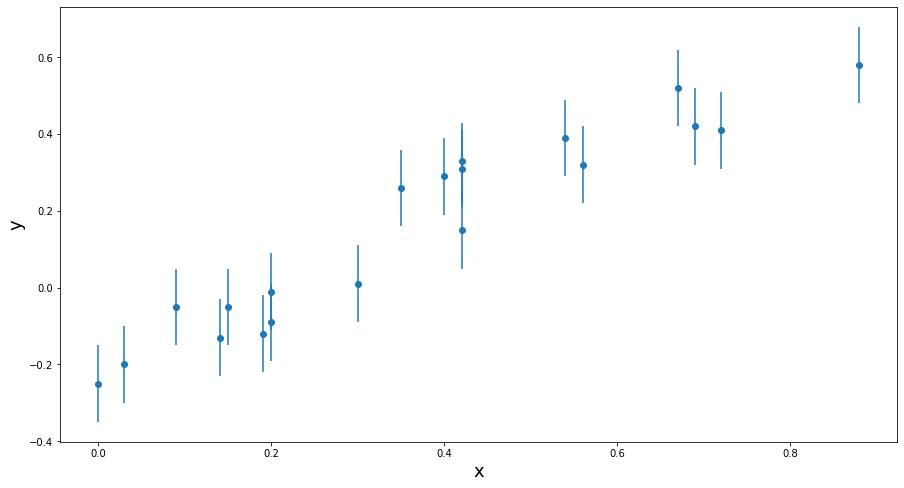

In [69]:
data2=np.load('../../homeworks/hw_data/hw4_data_2.npy',allow_pickle=True)
print(np.shape(data2))
x,y,sigma_y=data2
plt.errorbar(x,y,sigma_y,ls='none',marker='o')
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)

2) Use the above code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

<ipython-input-70-55002376e702>:12: RuntimeWarning: divide by zero encountered in log
  lnpri=np.log(pri)


Text(0.5, 1.0, 'Posterior PDF')

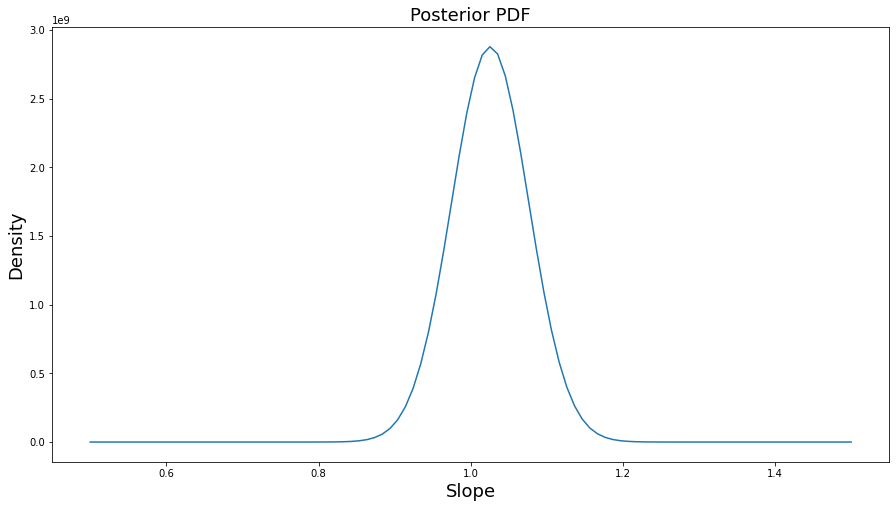

In [70]:
numpoints=100
intercept=-0.23
min_slope=0.5
max_slope=1.5

# Now theta is a list of slope values
theta=np.linspace(min_slope,max_slope,num=numpoints)

lnlike=[logL([intercept,i],data2) for i in theta]

pri=prior(theta,minimum=0.5,maximum=1.5)
lnpri=np.log(pri)


lnpost=lnpri+lnlike
post=np.exp(lnpost)

plt.plot(theta,post)
plt.xlabel('Slope',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Posterior PDF',fontsize=18)

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

In [71]:
linear_area=trapz(y=post,x=theta)

print("Bayesian Evidence: {:.1f}".format(linear_area))

Bayesian Evidence: 365684733.2


4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

In [72]:
numpoints=100
theta_0=-0.23
theta_1=np.linspace(0.5,1.5,num=numpoints)
theta_2=np.linspace(-1,0.25,num=numpoints)

prior_1=prior(theta_1,minimum=0.5,maximum=1.5)
prior_2=prior(theta_2,minimum=-1,maximum=0.25)

lnlike=np.zeros(shape=(numpoints,numpoints))
lnprior=np.zeros(shape=(numpoints,numpoints))
lnpost=np.zeros(shape=(numpoints,numpoints))


# CMD I wonder if it's possible to avoid the for loops here? I wasn't able to figure out a way to
for i in range(numpoints): #theta_1
    for j in range(numpoints): #theta_2
        lnlike[i,j]=logL([intercept,theta_1[i],theta_2[j]],data2)
        lnprior[i,j]=np.log(prior_1[i])+np.log(prior_2[j])
        
        lnpost[i,j]=lnlike[i,j]+lnprior[i,j]
        
post=np.exp(lnpost)

<ipython-input-72-4ca7c065f56e>:18: RuntimeWarning: divide by zero encountered in log
  lnprior[i,j]=np.log(prior_1[i])+np.log(prior_2[j])


Text(0.5, 1.0, 'Posterior PDF')

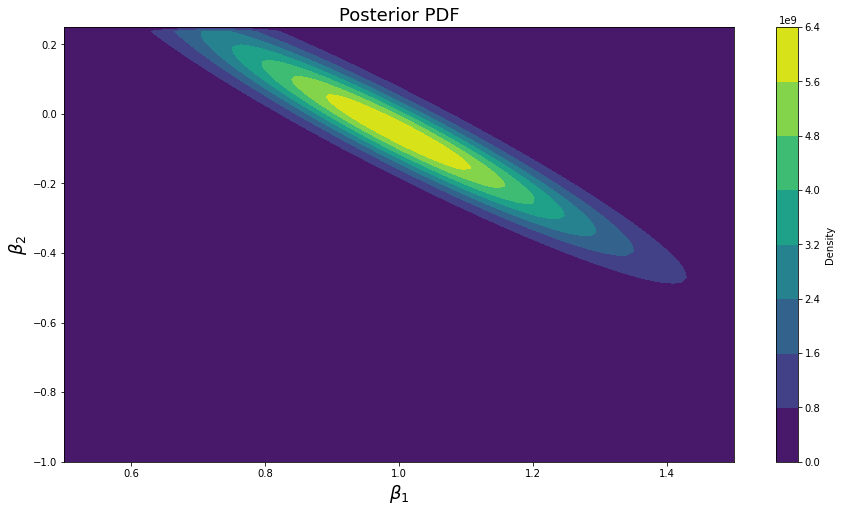

In [73]:
X, Y = np.meshgrid(theta_1, theta_2)
CS=plt.contourf(X,Y,post)
plt.colorbar(CS,label='Density')
plt.xlabel(r'$\beta_1$',fontsize=18)
plt.ylabel(r'$\beta_2$',fontsize=18)
plt.title('Posterior PDF',fontsize=18)

Text(0.5, 1.0, 'log Posterior PDF')

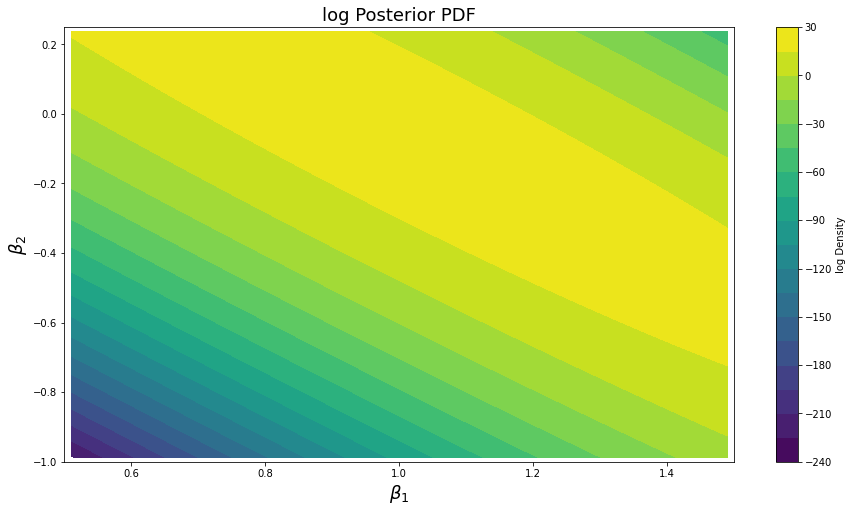

In [74]:
X, Y = np.meshgrid(theta_1, theta_2)
#levels=np.linspace(start=0,stop=25,num=10)
CS=plt.contourf(X,Y,lnpost,levels=20)
plt.colorbar(CS,label='log Density')
plt.xlabel(r'$\beta_1$',fontsize=18)
plt.ylabel(r'$\beta_2$',fontsize=18)
plt.title('log Posterior PDF',fontsize=18)

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

In [75]:
# numerical double integral
quad_area=trapz([trapz(i,theta_1) for i in post],theta_2)

print('Bayesian Evidence: {:.1f}'.format(quad_area))

Bayesian Evidence: 487806846.2


6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture?

In [79]:
bayes_factor=quad_area/linear_area

print("Linear Model Bayesian Evidence: {:.2e}".format(linear_area))
print("Quadratic Model Bayesian Evidence: {:.2e}".format(quad_area))
print("Bayes Factor for Quadratic Model (linear is NULL): {:.2f}".format(bayes_factor))

Linear Model Bayesian Evidence: 3.66e+08
Quadratic Model Bayesian Evidence: 4.88e+08
Bayes Factor for Quadratic Model (linear is NULL): 1.33


<font color='red'>In Lecture 9 the linear model had a lower (better) BIC value than the quadratic model. However, the quadratic model has a higher (better) Bayesian Evidence. This might imply that the Bayes factor does not have a very strong Occam penalty. Although in this case, the Bayes factor is not large enough to rule out the linear model.</font>